In [18]:
import sys
import gym
import copy
import pickle
%matplotlib notebook
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import filter_env
from ou_noise import OUNoise
from replay_buffer import ReplayBuffer
import gc
gc.enable()

In [19]:
# Hyperparameters/Settings
LOAD_NET = True
PATH_ROOT = 'save/'
CUDA = False

ENV_NAME = 'Pendulum-v0' #'InvertedPendulum-v1'
EPISODES = 100000
TEST = 10
TEST_STEP = 1 #100

LAYER1_SIZE = 400
LAYER2_SIZE = 300
LEARNING_RATE = 1e-4
TAU = 0.001
BATCH_SIZE = 32 #64

REPLAY_BUFFER_SIZE = 100000 #1000000
REPLAY_START_SIZE = 100 #10000
BATCH_SIZE = 64
GAMMA = 0.99

In [20]:
class ActorCriticNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorCriticNet, self).__init__()

        self.actor = ActorNet(state_dim, action_dim)
        self.critic = CriticNet(state_dim, action_dim)

    def forward(self, state):
        action = self.actor(state)
        value = self.critic(state, action)
        return value

    def getAction(self, state):
        return self.actor(state)

    def getValue(self, state, action=None):
        if action is None:
            return self.critic(state, self.actor(state))
        return self.critic(state, action)

    #def train(self): # might not be necessary
    #    self.critic.train()
    #    self.actor.train()
    
    #def eval(self): # might not be necessary
    #    self.critic.eval()
    #    self.actor.eval()

class CriticNet(nn.Module):

    def __init__(self, state_dim, action_dim):
        super(CriticNet, self).__init__()

        # make sure all params are initizialized randomly [-1/np.sqrt(dim),1/np.sqrt(dim)]
        self.layer1 = nn.Linear(state_dim,LAYER1_SIZE)
        self.action_layer = nn.Linear(action_dim,LAYER2_SIZE,bias=False)
        self.layer2 = nn.Linear(LAYER1_SIZE,LAYER2_SIZE)
        self.output_layer = nn.Linear(LAYER2_SIZE,1)

    def forward(self, state, action):
        x = F.relu(self.layer1(state))
        x = F.relu(self.action_layer(action) + self.layer2(x))
        q = self.output_layer(x)
        return q # predicted q value of this state-action pair

class ActorNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorNet, self).__init__()

        # make sure all params are initizialized randomly [-1/np.sqrt(dim),1/np.sqrt(dim)]
        self.layer0_bn = nn.BatchNorm1d(state_dim)
        self.layer1 = nn.Linear(state_dim,LAYER1_SIZE)
        self.layer1_bn = nn.BatchNorm1d(LAYER1_SIZE)
        self.layer2 = nn.Linear(LAYER1_SIZE,LAYER2_SIZE)
        self.layer2_bn = nn.BatchNorm1d(LAYER2_SIZE)
        self.output_layer = nn.Linear(LAYER2_SIZE,action_dim)

    def forward(self, state):
        x = F.relu(self.layer0_bn(state))
        x = self.layer1(x)
        x = F.relu(self.layer1_bn(x))
        x = self.layer2(x)
        x = F.relu(self.layer2_bn(x))
        action = F.tanh(self.output_layer(x))
        return action # predicted best actions

In [21]:
env = filter_env.makeFilteredEnv(gym.make(ENV_NAME))
state_dim = env.observation_space.shape[0]
action_dim =  env.action_space.shape[0]

stats = {'losses':[], 'losses_ep':[], 'rewards':[], 'rewards_ep':[]}
total_episodes = 0

if not LOAD_NET:
    net = ActorCriticNet(state_dim,action_dim)
    target_net = copy.deepcopy(net)
    memory = ReplayBuffer(REPLAY_BUFFER_SIZE)
    noise = OUNoise(action_dim)
else:
    net = torch.load(PATH_ROOT + 'saved_net')
    target_net = torch.load(PATH_ROOT + 'saved_target_net')
    memory = pickle.load(file(PATH_ROOT +'saved_memory','r'))
    noise = pickle.load(file(PATH_ROOT +'saved_noise','r'))
    for n in stats:
        stats[n] = np.load(PATH_ROOT + n + '.npy').tolist()
    total_episodes = stats['losses_ep'][-1]

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
target_optim = optim.Optimizer(target_net.parameters(), {}) # to iterate over target params


[2017-08-07 11:02:24,937] Making new env: Pendulum-v0


True action space: [-2.], [ 2.]
True state space: [-1. -1. -8.], [ 1.  1.  8.]
Filtered action space: [-1.], [ 1.]
Filtered state space: [-1. -1. -1.], [ 1.  1.  1.]


In [16]:
for episode in xrange(EPISODES):

    total_episodes += 1
    print 'Episode', total_episodes

    net.train()
    target_net.train() # not really necessary?

    state = torch.from_numpy(env.reset().reshape(1,state_dim)).float()
    if CUDA:
        state = state.cuda()
    
    noise.reset()
    
    train_steps = 0
    train_loss = 0

    # Train
    for step in xrange(env.spec.timestep_limit):

        # Take noisy action - for exploration
        action = net.getAction(Variable(state)).data + torch.from_numpy(noise.noise()).float()
        #print step, 'a', action.size()
        new_state, reward, done, _ = env.step(action.numpy().reshape((action_dim,)))
        
        new_state = torch.from_numpy(new_state.reshape(1,state_dim)).float()
        if CUDA:
            new_state = new_state.cuda()
        reward = torch.FloatTensor([reward]).float()
        if CUDA:
            reward = reward.cuda()
        #print step, 's', new_state.size()
        
        memory.add(state,action,reward,new_state,done)
        if memory.count() > REPLAY_START_SIZE:
            minibatch = memory.get_batch(BATCH_SIZE)
            state_batch = torch.cat([data[0] for data in minibatch],dim=0)
            action_batch = torch.cat([data[1] for data in minibatch],dim=0)
            reward_batch = torch.cat([data[2] for data in minibatch])
            next_state_batch = torch.cat([data[3] for data in minibatch])
            done_batch = Tensor([data[4] for data in minibatch])
            if CUDA:
                done_batch = done_batch.cuda()
            
            # calculate y_batch from targets
            #next_action_batch = target_net.getAction(Variable(next_state_batch))
            value_batch = target_net.getValue(Variable(next_state_batch)).data
            y_batch = reward_batch + GAMMA * value_batch * done_batch
            
            # optimize net 1 step
            loss = criterion(net.getValue(Variable(state_batch)), Variable(y_batch))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update targets - using exponential moving averages
            for group, target_group in zip(optimizer.param_groups, target_optim.param_groups):
                for param, target_param in zip(group['params'], target_group['params']):
                    target_param.data.mul_(1 - TAU)
                    target_param.data.add_(TAU, param.data)
                    
            train_steps += 1
            train_loss += loss.data[0]

        state = new_state
        if done: break

    stats['losses'].append(train_loss / train_steps)
    stats['losses_ep'].append(total_episodes)
    print '\tTraining: Average Loss:', stats['losses'][-1]

    # Test
    if episode % TEST_STEP == 0 and total_episodes > TEST_STEP:
        net.eval() # set to eval - important for batch normalization
        total_reward = 0
        for i in xrange(TEST):
            state = torch.from_numpy(env.reset().reshape(1,state_dim)).float()
            if CUDA:
                state = state.cuda()
            for j in xrange(env.spec.timestep_limit):
                
                action = net.getAction(Variable(state)).data # direct action for test
                state, reward, done, _ = env.step(action.numpy().reshape((action_dim,)))
                state = torch.from_numpy(state.reshape(1,state_dim)).float()
                if CUDA:
                    state = state.cuda()
                total_reward += reward
                if done: break
        ave_reward = total_reward / TEST
        print '\tTesting: Average Reward:', ave_reward
        stats['rewards'].append(ave_reward)
        stats['rewards_ep'].append(total_episodes)

Episode 1287
	Training: Average Loss: 0.287551530507
	Testing: Average Reward: -1263.37983492
Episode 1288


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


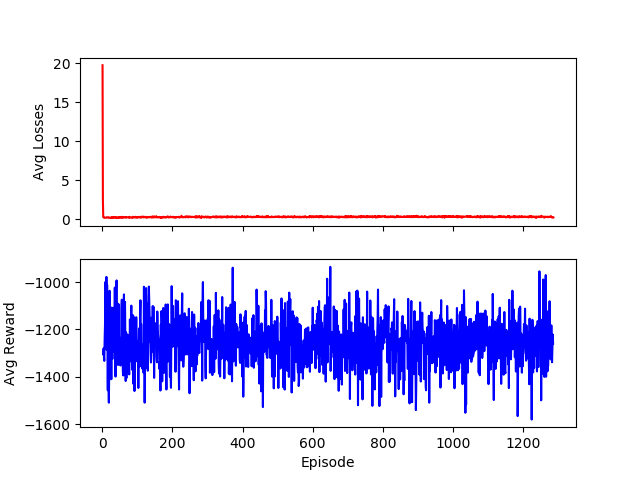

In [56]:
fig, (ax1,ax2) = plt.subplots(2,sharex=True)
ax1.plot(stats['losses_ep'],stats['losses'],'r')
ax2.plot(stats['rewards_ep'], stats['rewards'],'b')
ax1.set_ylabel('Avg Losses')
ax2.set_ylabel('Avg Reward')
ax2.set_xlabel('Episode')
plt.show()

In [ ]:
torch.save(net, PATH_ROOT + 'saved_net')
torch.save(net, PATH_ROOT + 'saved_target_net')

pickle.dump(memory,file(PATH_ROOT + 'saved_memory','w'))
pickle.dump(noise,file(PATH_ROOT + 'saved_noise','w'))
for n in stats:
    np.save(PATH_ROOT + n, np.array(stats[n]))
    

In [17]:
print net.getAction(Variable(state))

Variable containing:
-0.9424
[torch.FloatTensor of size 1x1]

